In [2]:
%matplotlib inline
import pykat
import pykat.optics.ABCD as abcd
import pylab as pl
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

### My functions
from kat_commands import *
from MMT import *
from cav_commands import *
from load_kat_data import *
import get_WS
import trace_mode

                                              ..-
    PyKat 1.0.19          _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



In [3]:
kat_code = """
# Laser input
l l1 $Pin 0 nin
s s1 0 nin nprc1

# Power recycling mirror
m1 prm $prmT 37.5u 90 nprc1 nprc2
s prc $lprc nprc2 nbsin

# Central beamsplitter
bs bs1 .5 .5 0 45 nbsin n0y n0x nbsout

# X-arm
s ichx $lmichx n0x n1x
m1 itmx $itmT 37.5u 90 n1x n2x
s armx $Larm n2x n3x
m1 etmx 5u 37.5u 89.999875 n3x n4x
attr itmx mass $Mtm zmech sus1
attr etmx mass $Mtm zmech sus1

# Y-arm
s ichy $lmichy n0y n1y
m1 itmy $itmT 37.5u 0.000125  n1y n2y
s army $Larm n2y n3y
m1 etmy 5u 37.5u 0.0035 n3y n4y
attr itmy mass $Mtm zmech sus1
attr etmy mass $Mtm zmech sus1

# Signal recycling mirror
s src $lsrc nbsout nsrc1
m1 srm $srmT 46.2u $srm_phi nsrc1 nsrc2

pd1 asport $fs nsrc2 % photo detector in South port

# Force-to-position transfer function for longitudinal
# motions of test masses
tf sus1 1 0 p $mech_fres $mech_Q
const mech_fres 1 # 9 sus-thermal spike
const mech_Q 1M # Guess for suspension Q factor

# DC readout: 100mW = michy_phi 0.07 _or_ darm_phi .00025

const Larm 3994.5
const itmT 0.014
const srmT 0.35
const prmT 0.03
const Pin 125
const Mtm 40
const srm_phi -90
const lmichx 4.5
const lmichy 4.45
const lprc 53
const lsrc 50.525

attr itmy Rc -1934
attr etmy Rc 2245

attr itmx Rc -1934
attr etmx Rc 2245
"""

pd_output = """
xaxis etmy phi lin 0 360 100 % changing the microscopic position of mN
"""

darm_commands1 = """
# A squeezed source could be injected into the dark port
sq sq1 0 0 90 nsrc2
# Differentially modulate the arm lengths
fsig darm armx 1 0
fsig darm2 army 1 180

qnoisedS NSR_with_RP 1 $fs nsrc2

qshotS NSR_without_RP 1 $fs nsrc2

xaxis darm f log 10 5k 1000
yaxis log abs
"""

In [4]:
### Full Dual Recycled FP Michaelson
basekat = pykat.finesse.kat() 
basekat.parseCommands(kat_code)
basekat.parseCommands(darm_commands1)
basekat.undumpNodes() #undump the vacuum nodes to get the right quantum noise
kat=basekat.deepcopy() #copy kat code
kat.verbose = False

out = kat.run()

In [5]:
### Turn off SRC, so on PRC FP IFO
basekat1 = pykat.finesse.kat() 
basekat1.parseCommands(kat_code)
basekat1.parseCommands(darm_commands1)
basekat1.undumpNodes() #undump the vacuum nodes to get the right quantum noise
kat1=basekat1.deepcopy() #copy kat code
kat1.verbose = False

kat1.srm.T.value = 1.0
kat1.srm.L.value = 0.0
kat1.srm.R.value = 0.0

out1 = kat1.run()

In [6]:
### Turn off PRC and SRC, so only FP IFO
basekat2 = pykat.finesse.kat() 
basekat2.parseCommands(kat_code)
basekat2.parseCommands(darm_commands1)
basekat2.undumpNodes() #undump the vacuum nodes to get the right quantum noise
kat2=basekat2.deepcopy() #copy kat code
kat2.verbose = False

kat2.prm.T.value = 1.0
kat2.prm.L.value = 0.0
kat2.prm.R.value = 0.0

out2 = kat2.run()

In [7]:
### Advanced LIGO design
katfile = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified.kat" 

basekat3 = pykat.finesse.kat() 
basekat3.loadKatFile(katfile)
basekat3.parseCommands(darm_commands)
basekat3.undumpNodes() #undump the vacuum nodes to get the right quantum noise
kat3=basekat3.deepcopy() #copy kat code
kat3.verbose = False

out3 = kat3.run()

Parsing `dbs OPP nOPb nOPc nOPd nOPz` into pykat object not implemented yet, added as extra line.


In [8]:
### Advanced LIGO design + 10 db Squeezing + FC

basekat4 = pykat.finesse.kat() 
basekat4.loadKatFile(katfile)
basekat4.parseCommands(darm_commands)
basekat4.parseCommands(add_squeezing)
basekat4.undumpNodes() #undump the vacuum nodes to get the right quantum noise
kat4=basekat4.deepcopy() #copy kat code
kat4.verbose = False

out4 = kat4.run()

Parsing `dbs OPP nOPb nOPc nOPd nOPz` into pykat object not implemented yet, added as extra line.


C:\Users\tvo88\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


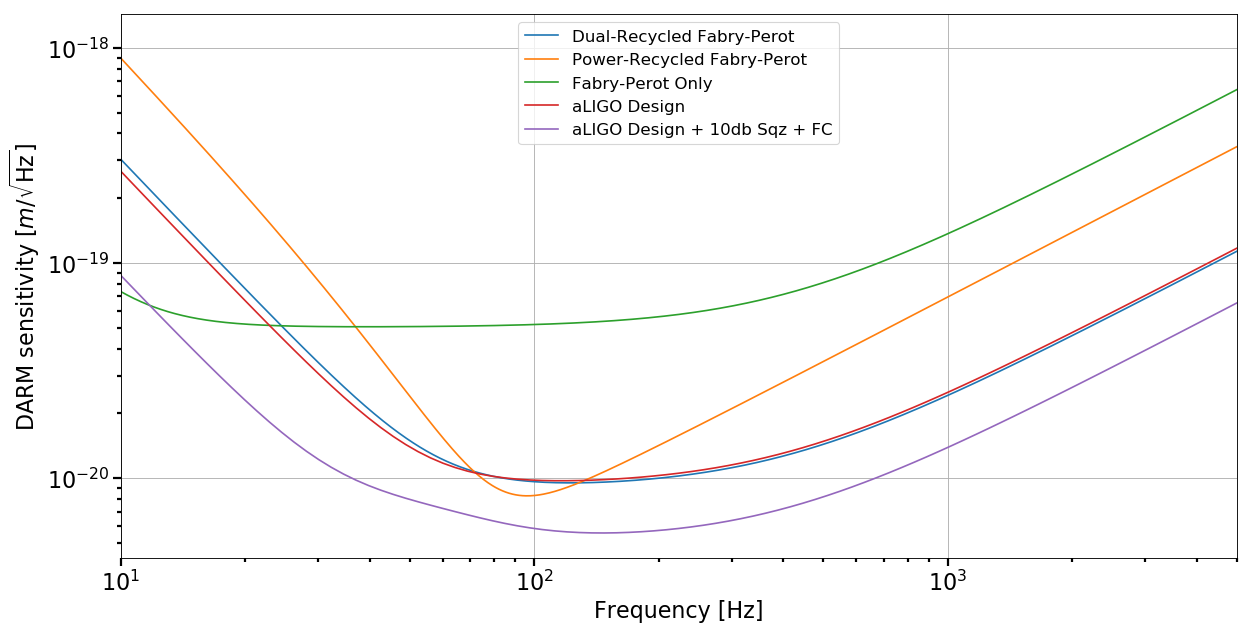

In [9]:
pl.figure(figsize=(18, 9), dpi=80)

pl.subplot(111)

pl.loglog(out.x,4e3*out['NSR_with_RP'],label='Dual-Recycled Fabry-Perot')
pl.loglog(out1.x,4e3*out1['NSR_with_RP'],label='Power-Recycled Fabry-Perot')
pl.loglog(out2.x,4e3*out2['NSR_with_RP'],label='Fabry-Perot Only')
pl.loglog(out3.x,4e3*out3['NSR_with_RP'],label='aLIGO Design')
pl.loglog(out4.x,4e3*out4['NSR_with_RP'],label='aLIGO Design + 10db Sqz + FC')

pl.legend(fontsize=15)

pl.xlim(out.x.min(),out.x.max())
pl.xlabel("Frequency [Hz]",fontsize=20)
pl.ylabel("DARM sensitivity [$m/\\sqrt{\mathrm{Hz}}$]",fontsize=20)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)

pl.show()